## MACD strategy

In [77]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
import matplotlib.ticker as mticker

In [78]:
path = "data/round_1"


def get_prices(round: int, day: int):

    path = f"data/round_{round}/prices_round_{round}_day_{day}.csv"

    return pd.read_csv(path, sep=";")


def get_trades(round: int, day: int):

    path = f"data/round_{round}/trades_round_{round}_day_{day}.csv"

    return pd.read_csv(path, sep=";")

prices = get_prices(1, -2)
trades = get_trades(1, -1)

def calculate_MACD(
    data: pd.DataFrame,
    price_col: str,
    short_window: int,
    long_window: int,
    smoothing_window: int,
    min_periods: int,
):

    # Calculate the 12-period EMA

    ema_short = data[price_col].ewm(span=short_window, adjust=False).mean()

    ema_long = data[price_col].ewm(span=long_window, adjust=False).mean()

    macd = ema_short - ema_long

    signal = macd.ewm(span=smoothing_window, adjust=False).mean()

    macd.iloc[:min_periods] = np.nan

    signal.iloc[:min_periods] = np.nan

    return macd, signal, ema_short, ema_long



def plot_MACD(prices: pd.DataFrame, macd, signal, ema_short, ema_long):
    fig = plt.figure(figsize=(25, 10))

    gs = GridSpec(2, 1, height_ratios=[2, 1.5], figure=fig)

    price_ax = plt.subplot(gs[0])

    macd_ax = plt.subplot(gs[1])

    price_ax.plot(prices["timestamp"], prices["mid_price"])
    price_ax.plot(prices["timestamp"], ema_short, label="Short EMA", color="green")
    price_ax.plot(prices["timestamp"], ema_long, label="Long EMA", color="red")
    price_ax.legend()

    macd_ax.plot(macd, color="red", label="MACD")
    macd_ax.plot(signal, color="green", label="Signal")
    macd_ax.legend()

    plt.show()

def analyze_product_MACD(prices, product_name, short_window, long_window, smoothing_window):
    # Sort the overall prices DataFrame
    prices.sort_values(["product", "timestamp"], inplace=True)
    
    # Filter for the specific product and sort by timestamp
    product_data = prices[prices["product"] == product_name].sort_values("timestamp")
    
    # Calculate MACD components
    macd, signal, ema_short, ema_long = calculate_MACD(
        product_data, "mid_price", short_window, long_window, smoothing_window, 50
    )
    
    # Plot MACD
    plot_MACD(product_data, macd, signal, ema_short, ema_long)
    
    return macd, signal, ema_short, ema_long

def generate_MACD_signals(product_data, ema_short, ema_long):
    # Generate position: long (1) if ema_short > ema_long, short (-1) otherwise
    product_data["position"] = np.where(ema_short > ema_long, 1, -1)
    
    # Calculate daily returns
    product_data["ret"] = product_data["mid_price"].pct_change()
    
    # Calculate strategy returns
    product_data["strategy_ret"] = product_data["ret"] * product_data["position"].shift(1)
    
    # Calculate cumulative strategy returns
    product_data["cum_strategy_ret"] = (1 + product_data["strategy_ret"]).cumprod()
    
    # Identify entry and exit points
    product_data["is_entry_point"] = (product_data["position"] == 1) & (product_data["position"].shift(1) == -1)
    product_data["is_exit_point"] = (product_data["position"] == -1) & (product_data["position"].shift(1) == 1)
    
    return product_data

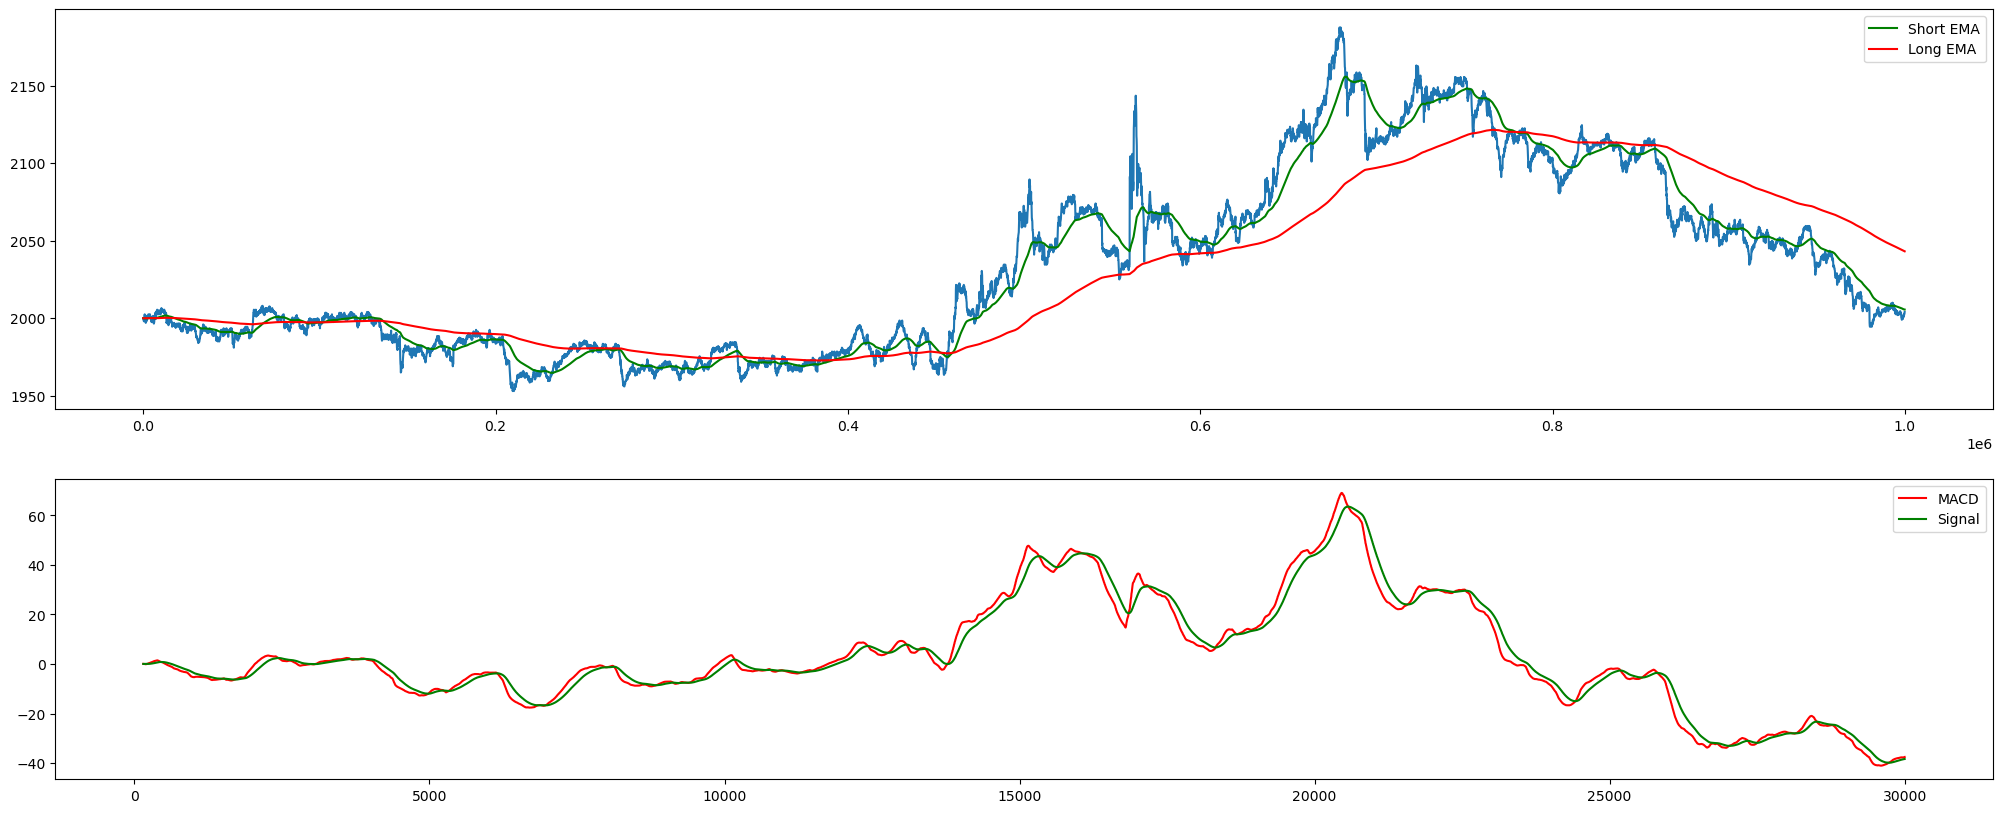

In [79]:
SHORT_WINDOW = 200
LONG_WINDOW = 1500
SMOOTHING_WINDOW = 100

macd, signal, ema_short, ema_long = analyze_product_MACD(
    prices, "SQUID_INK", SHORT_WINDOW, LONG_WINDOW, SMOOTHING_WINDOW
)

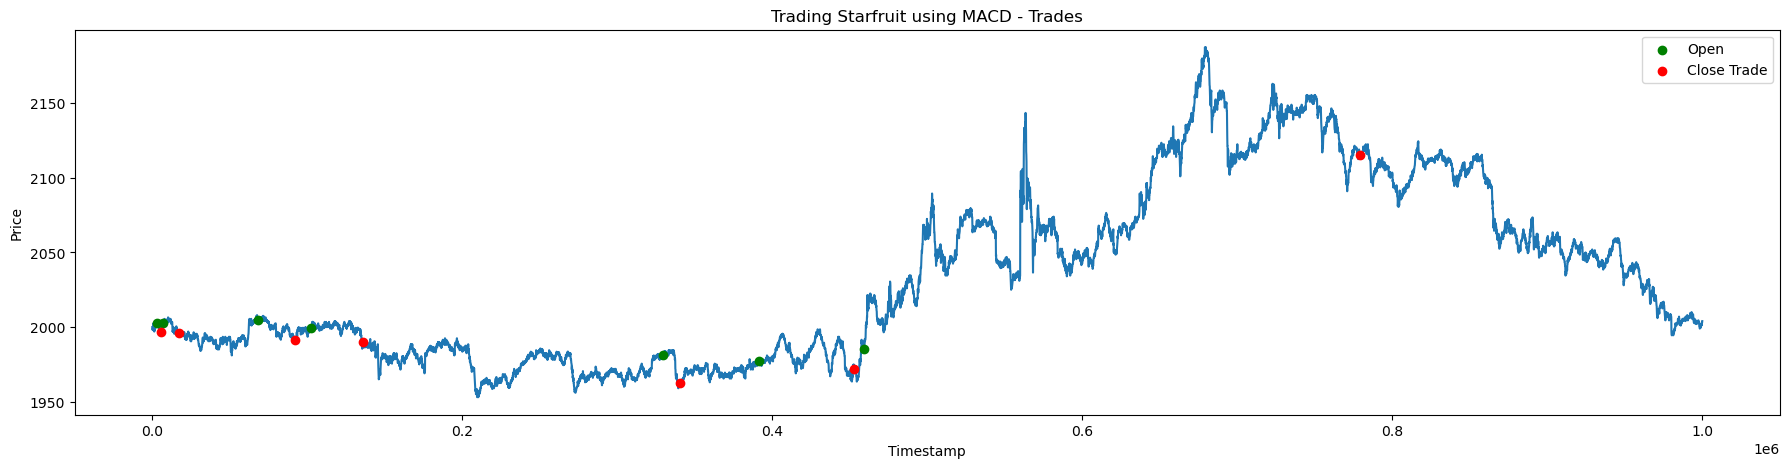

In [80]:
def plot_trades(data: pd.DataFrame, from_timestamp: int):
    fig, ax = plt.subplots(figsize=(22, 5))

    data = data[data["timestamp"] > from_timestamp].copy()

    ax.plot(data["timestamp"], data["mid_price"])

    entries = data[data["is_entry_point"]]
    exits = data[data["is_exit_point"]]

    for i, trade_series in enumerate([entries, exits]):
        color = "green" if i == 0 else "red"
        label = "Open" if i == 0 else "Close" + " Trade"
        ax.scatter(
            trade_series["timestamp"],
            trade_series["mid_price"],
            color=color,
            label=label,
            zorder=i + 2,
        )

    ax.legend()
    ax.set_title("Trading Starfruit using MACD - Trades")
    ax.set_xlabel("Timestamp")
    ax.set_ylabel("Price")


plot_trades(SQUID_INK, 0)

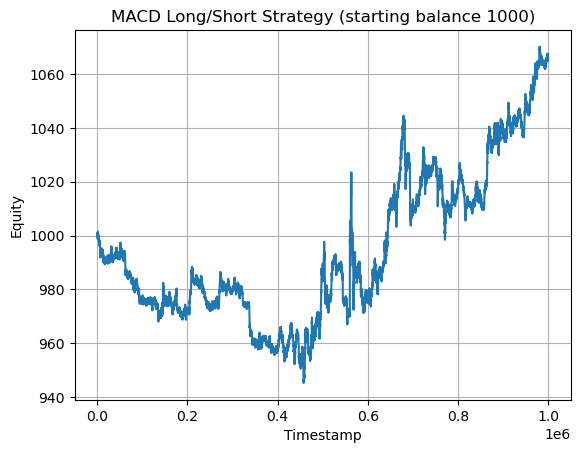

In [81]:
equity_curve = 1000 * SQUID_INK["cum_strategy_ret"]

plt.plot(SQUID_INK["timestamp"], equity_curve)
plt.title("MACD Long/Short Strategy (starting balance 1000)")
plt.xlabel("Timestamp")
plt.ylabel("Equity")
plt.grid(True)
plt.show()